# Gamma-gamma model

Comparison with lifetimes

**Reference**:Fader, P. S., & Hardie, B. G. (2013). The Gamma-Gamma model of monetary value. February, 2, 1-9.

http://www.brucehardie.com/notes/025/gamma_gamma.pdf

In [1]:
import arviz as az
import matplotlib.pyplot as plt

In [2]:
from pymc_marketing import clv

In [3]:
# Extra dependency for this notebook
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
from lifetimes import GammaGammaFitter

## Load data

In [4]:
summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

returning_customers_summary.head()

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
6,7,29.43,38.86,73.74
7,1,5.00,38.86,11.77
9,2,35.71,38.86,25.55


## Lifetimes implementation

In [5]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>

In [6]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,6.248802,1.189687,3.917016,8.580589
q,3.744588,0.290166,3.175864,4.313313
v,15.447748,4.159994,7.294160,23.601336


In [7]:
avg_profit = ggf.conditional_expected_average_profit(
    summary_with_money_value['frequency'],
    summary_with_money_value['monetary_value']
)
avg_profit.head(10)

customer_id
1     24.658616
2     18.911480
3     35.171002
4     35.171002
5     35.171002
6     71.462851
7     18.911480
8     35.171002
9     27.282408
10    35.171002
dtype: float64

In [8]:
avg_profit.mean()

35.25295817605011

## PyMMMC implementation

We can use the pre-built PyMMMC implementation of the Gamma-Gamma model, which also provides nice ploting and prediction methods

In [9]:
model = clv.GammaGammaModel(
    customer_id=returning_customers_summary.index,
    mean_transaction_value=returning_customers_summary["monetary_value"],
    frequency=returning_customers_summary["frequency"],
)

In [10]:
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [11]:
model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


Inference data with groups:
	> posterior
	> sample_stats

In [12]:
model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,6.497,1.458,4.221,9.142,0.062,0.045,652.0,872.0,1.00
q,3.776,0.298,3.254,4.374,0.011,0.008,735.0,1226.0,1.00
v,15.910,4.454,7.922,24.294,0.176,0.125,605.0,931.0,1.01


In [13]:
expected_spend = model.expected_customer_spend(
    customer_id=summary_with_money_value.index,
    mean_transaction_value=summary_with_money_value["monetary_value"],
    frequency=summary_with_money_value["frequency"],
)

Sampling: [nu]


In [14]:
az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
mean_spend[1],24.720,6.622,13.379,36.506
mean_spend[2],18.779,6.801,8.758,30.398
mean_spend[3],35.699,26.940,8.895,78.533
mean_spend[4],35.628,28.499,8.480,75.940
mean_spend[5],34.951,23.700,7.515,73.611
mean_spend[6],71.274,10.649,53.713,92.637
mean_spend[7],18.971,7.008,8.979,31.624
mean_spend[8],35.777,28.661,8.885,75.937
mean_spend[9],27.337,7.147,15.856,41.006
mean_spend[10],34.931,26.470,8.504,71.617


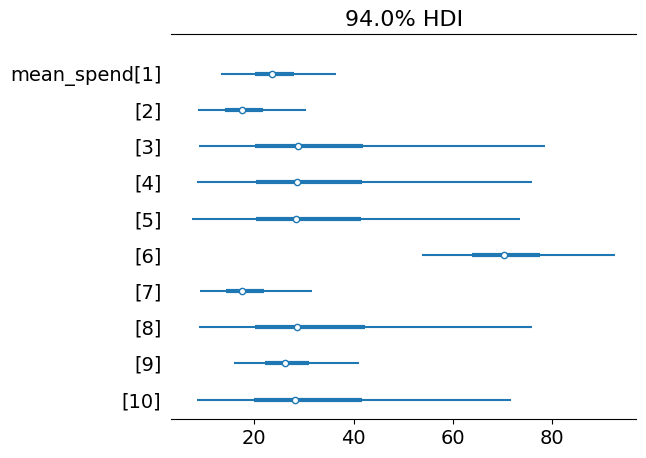

In [15]:
az.plot_forest(expected_spend.isel(customer_id=(range(10))), combined=True);

In [16]:
az.summary(expected_spend.mean("customer_id"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
mean_spend,35.253,0.783,33.79,36.718


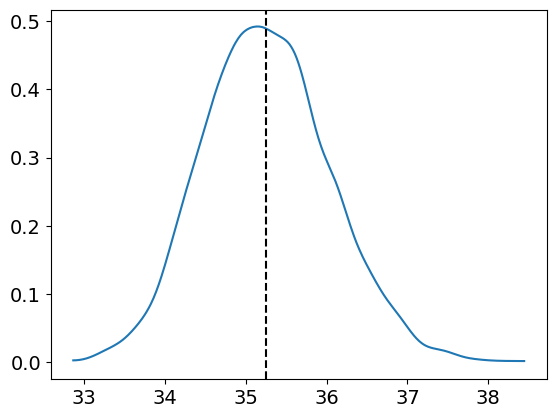

In [17]:
az.plot_dist(expected_spend.mean("customer_id"))
plt.axvline(expected_spend.mean(), color="k", ls="--")

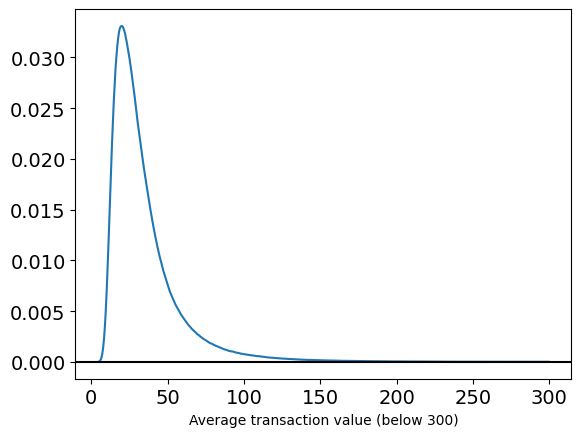

In [18]:
x = expected_spend.values.ravel()
az.plot_dist(x[x < 300])
plt.axhline(0, color="k")
plt.xlabel("Average transaction value (below 300)");